# Super-resolution of Burgers' equation

This notebook reconstructs Figure 1 from our paper [Learning data-driven discretizations for partial differential equations](https://www.pnas.org/content/116/31/15344), training a model from scratch.

This is useful for gaining insight about these methods (and our code), but it's worth reiterating that this model *not* one that we used for actual time-integration.

### Copyright 2019 Google LLC

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

## Setup environment

In [0]:
! pip install -q -U xarray matplotlib
! rm -rf data-driven-discretization-1d
! git clone https://github.com/google/data-driven-discretization-1d.git
! pip install -q -e data-driven-discretization-1d
# install the seaborn bug-fix from https://github.com/mwaskom/seaborn/pull/1602
! pip install -U -q git+git://github.com/stfnrpplngr/seaborn.git@309a9de383fac4db1c66dbf87815c4ba0c439c59


In [0]:
# Ensure we're using Tensorflow 1.x in Colab. If not using Colab, remove this magic.
%tensorflow_version 1.x
import tensorflow as tf
assert tf.__version__[:2] == '1.'

import seaborn
assert seaborn.__version__ == '0.9.0', 'restart kernel after running previous cell'
from matplotlib.colors import LogNorm

import enum
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import sys, time, os, h5py

import os
import json
import numpy as np
import seaborn
import pandas as pd
import xarray
import matplotlib.pyplot as plt

import pde_superresolution.utils
import pde_superresolution as pde


## Library code

### dataset generation

In [0]:

def _stack_all_rolls(inputs: tf.Tensor, max_offset: int) -> tf.Tensor:
  """Stack together all rolls of inputs, from 0 to max_offset."""
  rolled = [tf.concat([inputs[i:, ...], inputs[:i, ...]], axis=0)
            for i in range(max_offset)]
  return tf.stack(rolled, axis=0)


@enum.unique
class Dataset(enum.Enum):
  TRAINING = 0
  VALIDATION = 1


def _model_inputs(fine_inputs, resample_factor):
  inputs = fine_inputs[:, resample_factor-1::resample_factor]

  labels = tf.stack([fine_inputs[:, offset-1::resample_factor]
                     for offset in range(1, resample_factor)], axis=-1)

  base_grid = pde.polynomials.regular_grid(
      pde.polynomials.GridOffset.STAGGERED, derivative_order=0,
      accuracy_order=hparams.coefficient_grid_min_size, dx=1)
  baselines = []
  for offset in range(1, hparams.resample_factor):
    current_grid = base_grid + 0.5 - offset / hparams.resample_factor
    method = pde.polynomials.Method.FINITE_DIFFERENCES
    reconstruction = pde.polynomials.reconstruct(
        inputs, current_grid, method, derivative_order=0)
    baselines.append(reconstruction)
  baseline = tf.stack(baselines, axis=-1)

  results = {'inputs': inputs, 'labels': labels, 'baseline': baseline}

  for accuracy_order in [1, 3, 5]:
    base_grid = pde.polynomials.regular_grid(
        pde.polynomials.GridOffset.STAGGERED, derivative_order=0,
        accuracy_order=accuracy_order, dx=1)
    baselines = []
    for offset in range(1, hparams.resample_factor):
      current_grid = base_grid + 0.5 - offset / hparams.resample_factor
      method = pde.polynomials.Method.FINITE_DIFFERENCES
      reconstruction = pde.polynomials.reconstruct(
          inputs, current_grid, method, derivative_order=0)
      baselines.append(reconstruction)
    results[f'baseline_{accuracy_order}'] = tf.stack(baselines, axis=-1)

  return results


def make_dataset(snapshots,
                 hparams,
                 dataset_type: Dataset = Dataset.TRAINING,
                 repeat: bool = True,
                 evaluation: bool = False) -> tf.data.Dataset:
  snapshots = np.asarray(snapshots, dtype=np.float32)

  num_training = int(round(snapshots.shape[0] * hparams.frac_training))
  if dataset_type is Dataset.TRAINING:
    indexer = slice(None, num_training)
  else:
    assert dataset_type is Dataset.VALIDATION
    indexer = slice(num_training, None)

  dataset = tf.data.Dataset.from_tensor_slices(snapshots[indexer])
  # no need to do dataset augmentation with rolling for eval
  rolls_stop = 1 if evaluation else hparams.resample_factor
  dataset = dataset.map(lambda x: _stack_all_rolls(x, rolls_stop))
  dataset = dataset.map(lambda x: _model_inputs(x, hparams.resample_factor))
  dataset = dataset.apply(tf.data.experimental.unbatch())
  dataset = dataset.cache()

  if repeat:
    dataset = dataset.apply(
        tf.data.experimental.shuffle_and_repeat(buffer_size=10000))

  batch_size = hparams.base_batch_size * hparams.resample_factor
  dataset = dataset.batch(batch_size)
  dataset = dataset.prefetch(buffer_size=1)
  return dataset


def stack_reconstruction(inputs, predictions):
  if isinstance(inputs, tf.Tensor):
    stacked = tf.concat([predictions, inputs[..., tf.newaxis], ], axis=-1)
    return tf.layers.flatten(stacked)
  else:
    stacked = np.concatenate([predictions, inputs[..., np.newaxis]], axis=-1)
    new_shape = stacked.shape[:-2] + (np.prod(stacked.shape[-2:]),)
    return stacked.reshape(new_shape)

### model

In [0]:
def predict_coefficients(inputs: tf.Tensor,
                         hparams: tf.contrib.training.HParams,
                         reuse: object = tf.AUTO_REUSE) -> tf.Tensor:
  _, equation = pde.equations.from_hparams(hparams)
  pde.model.assert_consistent_solution(equation, inputs)

  with tf.variable_scope('predict_coefficients', reuse=reuse):
    num_derivatives = len(equation.DERIVATIVE_ORDERS)

    base_grid = pde.polynomials.regular_grid(
        pde.polynomials.GridOffset.STAGGERED, derivative_order=0,
        accuracy_order=hparams.coefficient_grid_min_size,
        dx=1.0)

    net = inputs[:, :, tf.newaxis]
    net /= equation.standard_deviation

    activation = pde.model._NONLINEARITIES[hparams.nonlinearity]

    for _ in range(hparams.num_layers - 1):
      net = pde.layers.conv1d_periodic_layer(net, filters=hparams.filter_size,
                                         kernel_size=hparams.kernel_size,
                                         activation=activation, center=True)

    poly_accuracy_layers = []
    for offset in range(1, hparams.resample_factor):
      current_grid = base_grid + 0.5 - offset / hparams.resample_factor
      method = pde.polynomials.Method.FINITE_DIFFERENCES
      poly_accuracy_layers.append(
          pde.polynomials.PolynomialAccuracyLayer(
              grid=current_grid,
              method=method,
              derivative_order=0,
              accuracy_order=hparams.polynomial_accuracy_order,
              out_scale=hparams.polynomial_accuracy_scale)
      )
    input_sizes = [layer.input_size for layer in poly_accuracy_layers]

    if hparams.num_layers > 0:
      net = pde.layers.conv1d_periodic_layer(net, filters=sum(input_sizes),
                                          kernel_size=hparams.kernel_size,
                                          activation=None, center=True)
    else:
      initializer = tf.initializers.zeros()
      coefficients = tf.get_variable(
          'coefficients', (sum(input_sizes),),
          initializer=initializer)
      net = tf.tile(coefficients[tf.newaxis, tf.newaxis, :],
                    [tf.shape(inputs)[0], inputs.shape[1].value, 1])

    cum_sizes = np.cumsum(input_sizes)
    starts = [0] + cum_sizes[:-1].tolist()
    stops = cum_sizes.tolist()
    zipped = zip(starts, stops, poly_accuracy_layers)

    outputs = tf.stack([layer.apply(net[..., start:stop])
                        for start, stop, layer in zipped], axis=-2)
    assert outputs.shape.as_list()[-1] == base_grid.size

    return outputs


def predict(inputs, hparams):
  coefficients = predict_coefficients(inputs, hparams)
  return pde.model.apply_coefficients(coefficients, inputs)


def setup_training(dataset, hparams, scale=1.0):
  tensors = dataset.make_one_shot_iterator().get_next()
  predictions = predict(tensors['inputs'], hparams)
  loss = tf.reduce_mean((tensors['labels'] - predictions) ** 2) / scale
  train_step = pde.training.create_training_step(loss, hparams)
  return loss, train_step


def baseline_loss(snapshots, hparams):
  dataset = make_dataset(snapshots, hparams, repeat=False, evaluation=True)

  tensors = dataset.make_one_shot_iterator().get_next()
  loss = tf.reduce_mean((tensors['labels'] - tensors['baseline_1']) ** 2)

  sess = tf.Session(config=pde.training._session_config())
  losses = []
  while True:
    try:
      losses.append(sess.run(loss))
    except tf.errors.OutOfRangeError:
      break
  return np.mean(losses)

## one time step

In [5]:
! gsutil cp gs://data-driven-discretization-public/training-data/burgers.h5 .

Copying gs://data-driven-discretization-public/training-data/burgers.h5...
- [1 files][ 39.1 MiB/ 39.1 MiB]                                                
Operation completed over 1 objects/39.1 MiB.                                     


In [0]:
with h5py.File('burgers.h5') as f:
  snapshots = f['v'][...]

## visualize an example

In [0]:
hparams = pde.training.create_hparams(
    equation='burgers',
    conservative=False,
    coefficient_grid_min_size=6,
    resample_factor=16,
    equation_kwargs=json.dumps(dict(num_points=512)),
    base_batch_size=32,
)

### Baseline performance

Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)`.


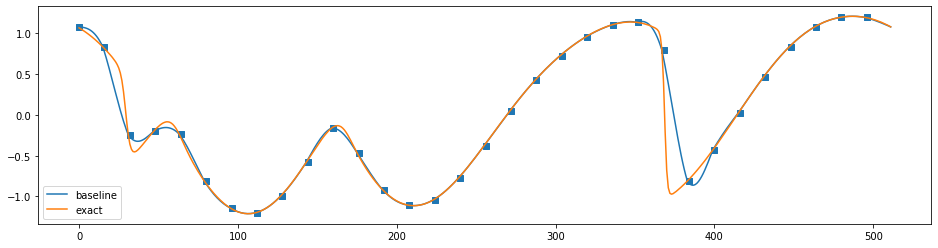

In [15]:
demo_dataset = make_dataset(snapshots, hparams, repeat=False, evaluation=True)

sess = tf.Session(config=pde.training._session_config())
tf_example = demo_dataset.make_one_shot_iterator().get_next()
example = sess.run(tf_example)

plt.figure(figsize=(16, 4))
example_id = 2
plt.scatter(np.arange(0, 512, hparams.resample_factor),
            np.roll(example['inputs'][example_id], 1, axis=-1), marker='s')
plt.plot(stack_reconstruction(example['inputs'], example['baseline'])[example_id], label='baseline')
plt.plot(stack_reconstruction(example['inputs'], example['labels'])[example_id], label='exact')
plt.legend()

### Untrained model

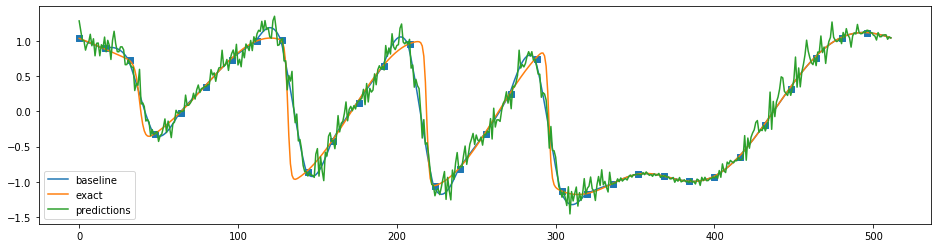

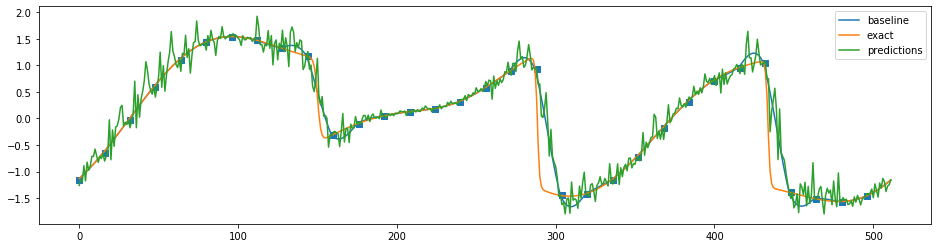

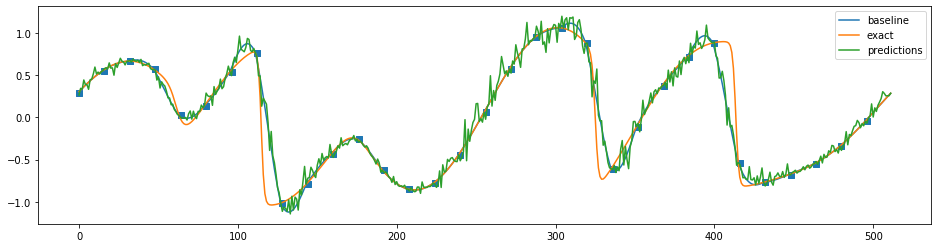

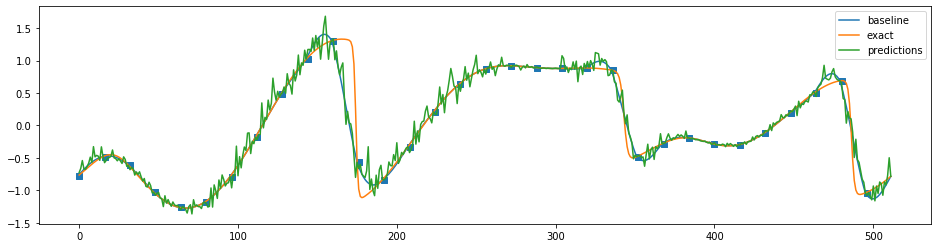

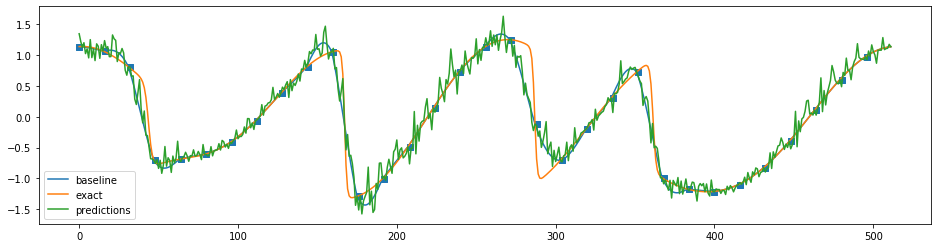

In [18]:
demo_dataset = make_dataset(snapshots, hparams, Dataset.VALIDATION, repeat=False, evaluation=True)

tensors = demo_dataset.make_one_shot_iterator().get_next()
tensors['predictions'] = predict(tensors['inputs'], hparams)
sess.run(tf.global_variables_initializer())
example = sess.run(tensors)

for example_id in [0, 10, 20, 30, 40]:
  plt.figure(figsize=(16, 4))
  plt.scatter(np.arange(0, 512, hparams.resample_factor),
              np.roll(example['inputs'][example_id], 1, axis=-1), marker='s')
  plt.plot(stack_reconstruction(example['inputs'], example['baseline'])[example_id], label='baseline')
  plt.plot(stack_reconstruction(example['inputs'], example['labels'])[example_id], label='exact')
  plt.plot(stack_reconstruction(example['inputs'], example['predictions'])[example_id], label='predictions')
  plt.legend()

## train a model (optional)

Note that below we'll download the saved results from a previous run.

In [0]:
hparams = pde.training.create_hparams(
    equation='burgers',
    conservative=False,
    coefficient_grid_min_size=6,
    resample_factor=8,
    equation_kwargs=json.dumps(dict(num_points=512)),
    eval_interval=500,
    learning_stops=[20000, 40000],
    learning_rates=[3e-3, 3e-4],
)
loss_scale = baseline_loss(snapshots, hparams)

In [20]:
%%time
tf.reset_default_graph()
dataset = make_dataset(snapshots, hparams)
loss, train_step = setup_training(dataset, hparams, scale=loss_scale)

sess = tf.Session(config=pde.training._session_config())
sess.run(tf.global_variables_initializer())

Instructions for updating:
Use `tf.data.Dataset.shuffle(buffer_size, seed)` followed by `tf.data.Dataset.repeat(count)`. Static tf.data optimizations will take care of using the fused implementation.




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
CPU times: user 1.23 s, sys: 58.6 ms, total: 1.29 s
Wall time: 1.31 s


In [21]:
%%time
for step in range(hparams.learning_stops[-1]):
  sess.run(train_step)
  if (step + 1) % hparams.eval_interval == 0:
    print(step, sess.run(loss))


499 0.035062023
999 0.02400635
1499 0.025569342
1999 0.016453508
2499 0.017697832
2999 0.009676907
3499 0.011365009
3999 0.0092496555
4499 0.014312735
4999 0.009259289
5499 0.011016512
5999 0.007732385
6499 0.008062332
6999 0.013416935
7499 0.0055208383
7999 0.0094934385
8499 0.006032483
8999 0.0072742663
9499 0.0054949825
9999 0.00783928
10499 0.010721574
10999 0.0072897924
11499 0.008039358
11999 0.005920907
12499 0.0062364563
12999 0.0043166806
13499 0.0037766579
13999 0.0049056956
14499 0.0049356623
14999 0.004917792
15499 0.004502083
15999 0.0045606075
16499 0.0051525976
16999 0.0035542285
17499 0.004582064
17999 0.004368516
18499 0.0039048584
18999 0.0041929362
19499 0.0052653076
19999 0.0041607423
20499 0.0038153687
20999 0.0032301648
21499 0.00384568
21999 0.0034206028
22499 0.0045954506
22999 0.0039034765
23499 0.0042015165
23999 0.003900434
24499 0.0043615797
24999 0.003726912
25499 0.003570927
25999 0.004892994
26499 0.00482392
26999 0.0029818115
27499 0.0029902444
27999 0.0

In [0]:
demo_dataset = make_dataset(snapshots, hparams, Dataset.VALIDATION, repeat=False, evaluation=True)

tensors = demo_dataset.make_one_shot_iterator().get_next()
tensors['predictions'] = predict(tensors['inputs'], hparams)

array_list = []
while True:
  try:
    array_list.append(sess.run(tensors))
  except tf.errors.OutOfRangeError:
    break
arrays = {k: np.concatenate([d[k] for d in array_list])
          for k in array_list[0]}

In [0]:
ds = xarray.Dataset({
    'inputs': (('sample', 'x'), arrays['inputs']),
    'labels': (('sample', 'x', 'offset'), arrays['labels']),
    'nn_predictions': (('sample', 'x', 'offset'), arrays['predictions']),
    'poly_predictions': (('sample', 'x', 'accuracy_order', 'offset'),
                          np.stack([arrays['baseline_1'],arrays['baseline_3'], arrays['baseline_5']], axis=-2)),
}, coords={'accuracy_order': [1, 3, 5]})

In [24]:
ds

<xarray.Dataset>
Dimensions:           (accuracy_order: 3, offset: 7, sample: 2000, x: 64)
Coordinates:
  * accuracy_order    (accuracy_order) int64 1 3 5
Dimensions without coordinates: offset, sample, x
Data variables:
    inputs            (sample, x) float32 0.97113955 0.8941418 ... -0.08285153
    labels            (sample, x, offset) float32 1.0328023 ... -0.10640238
    nn_predictions    (sample, x, offset) float32 1.0325156 ... -0.106427915
    poly_predictions  (sample, x, accuracy_order, offset) float32 1.0318207 ... -0.10643323

## Examine results from the trained model

In [0]:
!gsutil cp gs://data-driven-discretization-public/reconstruction/burgers_results_8x.nc .

Copying gs://data-driven-discretization-public/reconstruction/burgers_results_8x.nc...
/ [1 files][ 17.6 MiB/ 17.6 MiB]                                                
Operation completed over 1 objects/17.6 MiB.                                     


In [0]:
hparams = pde.training.create_hparams(
    equation='burgers',
    conservative=False,
    coefficient_grid_min_size=6,
    resample_factor=8,
    equation_kwargs=json.dumps(dict(num_points=512)),
    eval_interval=500,
    learning_stops=[20000, 40000],
    learning_rates=[3e-3, 3e-4],
)

In [0]:
ds = xarray.open_dataset('burgers_results_8x.nc').load()

In [28]:
ds

<xarray.Dataset>
Dimensions:           (accuracy_order: 3, offset: 7, sample: 2000, x: 64)
Coordinates:
  * accuracy_order    (accuracy_order) int32 1 3 5
Dimensions without coordinates: offset, sample, x
Data variables:
    labels            (sample, x, offset) float32 1.0328023 ... -0.10640238
    nn_predictions    (sample, x, offset) float32 1.0326428 ... -0.10649262
    poly_predictions  (sample, x, accuracy_order, offset) float32 1.0318207 ... -0.10643323
    inputs            (sample, x) float32 0.97113955 0.8941418 ... -0.08285153

## Figures

Overall histogram of absolut error

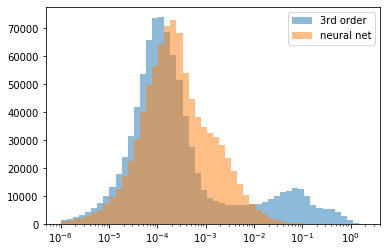

In [29]:
plt.hist(abs(ds.labels - ds.poly_predictions.sel(accuracy_order=3)).data.ravel(),
         bins=np.geomspace(1e-6, 2, num=51), alpha=0.5, label='3rd order');
plt.hist(abs(ds.labels - ds.nn_predictions).data.ravel(),
         bins=np.geomspace(1e-6, 2, num=51), alpha=0.5, label='neural net');
plt.xscale('log')
plt.legend()

Some full examples -- we are much better than third-order polynomial interpolation!

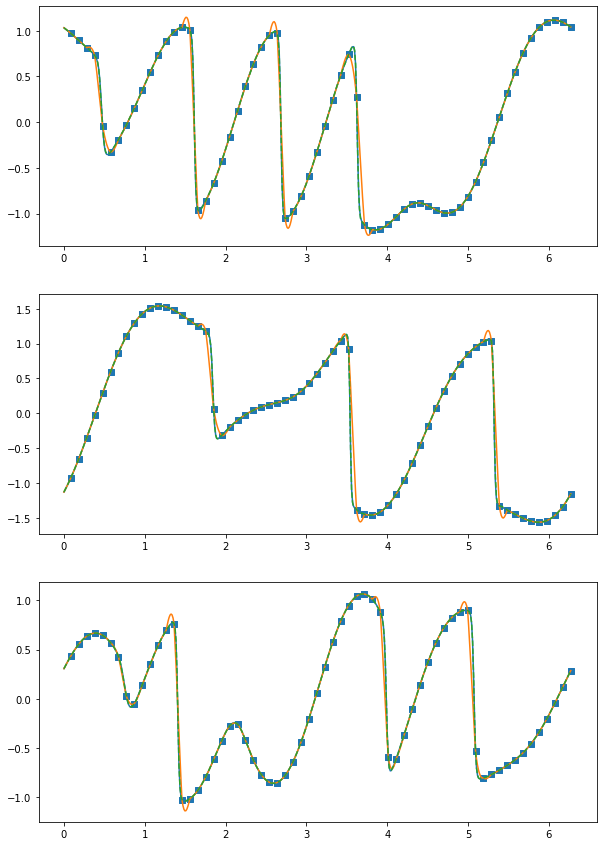

In [30]:
example_id = 0
fig, axes = plt.subplots(3, 1, figsize=(10, 15))
x = np.arange(512) * 2 * np.pi / 512
colors = seaborn.color_palette(n_colors=3)

for ax, example_id in zip(axes.ravel(), [0, 10, 20]):
  ax.scatter(x[hparams.resample_factor-1::hparams.resample_factor],
             ds.inputs.data[example_id],
             marker='s',  color=colors[0])
  ax.plot(x, stack_reconstruction(ds.inputs.data, ds.labels.data)[example_id],
          label='exact', color=colors[0])
  ax.plot(x, stack_reconstruction(ds.inputs.data, ds.poly_predictions.sel(accuracy_order=3).data)[example_id],
          label='baseline', color=colors[1])
  ax.plot(x, stack_reconstruction(ds.inputs.data, ds.nn_predictions.data)[example_id],
          label='predictions', linestyle='--', color=colors[2])


Create Figure 1 from the paper:

In [0]:
disc = xarray.Dataset()
disc['nn_error'] = abs(ds.nn_predictions - ds.labels).mean('offset')
disc['poly_error'] = abs(ds.poly_predictions.sel(accuracy_order=3) - ds.labels).mean('offset')

# https://en.wikipedia.org/wiki/Curvature#Curvature_of_the_graph_of_a_function
use_slope = 0
dx = 2*np.pi/512
y_xx = ds.labels.diff('offset', 2) / dx ** 2
y_x = 0.5 * (ds.labels.diff('offset').sel(offset=slice(None, -1)) + ds.labels.diff('offset').sel(offset=slice(1, None))) / dx
disc['bin_curvature'] = (abs(y_xx) / (1 + use_slope * y_x ** 2) ** (3/2)).max('offset')

y = stack_reconstruction(ds.inputs.data, ds.labels.data).astype(np.float64)
y_xx = (np.roll(y, -1, axis=-1) - 2 * y + np.roll(y, 1, axis=-1)) / dx ** 2
y_x = (0.5 * np.roll(y, -1, axis=-1) - 0.5 * np.roll(y, 1, axis=-1)) / dx
curvature = abs(y_xx) / (1 + use_slope * y_x ** 2) ** (3/2)
resample_factor = 8
curvature = np.stack([curvature[:, offset-1::resample_factor]
                      for offset in range(1, resample_factor)], axis=-1)
disc['curvature'] = ds.labels.copy(data=curvature)

disc['nearest_curvature'] = 10 ** np.log10(disc.bin_curvature).round(1)

df = disc.to_dataframe().reset_index()
curvature_count = (df.groupby('nearest_curvature').count())['sample']

In [0]:
import pandas as pd

# TODO(shoyer): upstream this into Seaborn

class CustomLinePlotter(seaborn.relational._LinePlotter):
    def aggregate(self, vals, grouper, units=None):
        """Compute an estimate and confidence interval using grouper."""
        func = self.estimator
        ci = self.ci
        n_boot = self.n_boot

        # Define a "null" CI for when we only have one value
        null_ci = pd.Series(index=["low", "high"], dtype=np.float)

        # Group and get the aggregation estimate
        grouped = vals.groupby(grouper, sort=self.sort)
        est = grouped.agg(func)

        lower = grouped.quantile(1 - ci)
        upper = grouped.quantile(ci)
        cis = pd.DataFrame(np.c_[lower, upper],
                            index=est.index,
                            columns=["low", "high"]).stack()

        # Unpack the CIs into "wide" format for plotting
        if cis.notnull().any():
            cis = cis.unstack().reindex(est.index)
        else:
            cis = None

        return est.index, est, cis

def custom_lineplot(x=None, y=None, hue=None, size=None, style=None, data=None,
             palette=None, hue_order=None, hue_norm=None,
             sizes=None, size_order=None, size_norm=None,
             dashes=True, markers=None, style_order=None,
             units=None, estimator="mean", ci=95, n_boot=1000,
             sort=True, err_style="band", err_kws=None,
             legend="brief", ax=None, **kwargs):

    p = CustomLinePlotter(
        x=x, y=y, hue=hue, size=size, style=style, data=data,
        palette=palette, hue_order=hue_order, hue_norm=hue_norm,
        sizes=sizes, size_order=size_order, size_norm=size_norm,
        dashes=dashes, markers=markers, style_order=style_order,
        units=units, estimator=estimator, ci=ci, n_boot=n_boot,
        sort=sort, err_style=err_style, err_kws=err_kws, legend=legend,
    )

    if ax is None:
        ax = plt.gca()

    p.plot(ax, kwargs)
    return ax



/usr/local/lib/python3.6/dist-packages/matplotlib/colors.py:1110: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


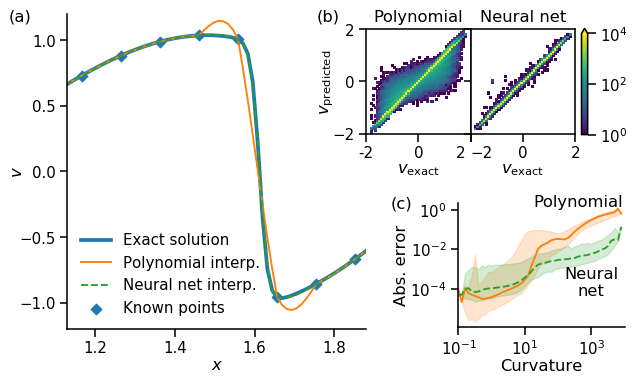

In [37]:
seaborn.set_context("notebook", font_scale=12/11)
fig = plt.figure(figsize=(2*3.42, 2*2))

# LEFT
example_id = 0
ax = fig.subplots(1, 1, gridspec_kw=dict(bottom=0.11, top=0.985, left=0.095, right=0.58))
x = np.arange(512) * 2 * np.pi / 512
colors = ['C0', 'C1', 'C2']
ax.scatter(x[hparams.resample_factor-1::hparams.resample_factor],
           ds.inputs.data[example_id],
           marker='D', label='Known points', color=colors[0])
ax.plot(x, stack_reconstruction(ds.inputs.data, ds.labels.data)[example_id],
         label='Exact solution',
         color=colors[0],
         linewidth=3,
         )
ax.plot(x, stack_reconstruction(ds.inputs.data, ds.poly_predictions.sel(accuracy_order=3).data)[example_id],
         label='Polynomial interp.', color=colors[1])
ax.plot(x, stack_reconstruction(ds.inputs.data, ds.nn_predictions.data)[example_id],
        label='Neural net interp.', linestyle='--', color=colors[-1])
ax.legend(frameon=False, loc='lower left')
ax.set_xlim(1.13, 1.88)
ax.set_ylim(-1.2, 1.2)
ax.set_xlabel('$x$', labelpad=1)
ax.set_ylabel('$v$', labelpad=-5)
seaborn.despine()

# TOP RIGHT
axes = fig.subplots(1, 2, sharex=False, sharey=True,
                    gridspec_kw=dict(bottom=0.65, top=0.945, left=0.58, right=0.92, wspace=0))
axes[0].set_aspect('equal')
axes[1].set_aspect('equal')

bins = np.linspace(-2, 2, num=51)
im = axes[0].hist2d(
    ds.labels.data.ravel(),
    ds.poly_predictions.sel(accuracy_order=3).data.ravel(),
    bins=2*[bins], cmin=1, norm=LogNorm(vmin=1, vmax=1e4))
im[-1].set_edgecolor('none')
im[-1].set_rasterized(True)
im[-1].set_zorder(-1)

im = axes[1].hist2d(
    ds.labels.data.ravel(), 
    ds.nn_predictions.data.ravel(),
    bins=2*[bins], cmin=1, norm=LogNorm(vmin=1, vmax=1e4))
im[-1].set_edgecolor('none')
im[-1].set_rasterized(True)
im[-1].set_zorder(-1)

cbaxes = fig.add_axes([0.93, 0.65, 0.01, 0.295]) 
cb = plt.colorbar(im[3], cax=cbaxes, extendfrac=0.05, extend='max')

axes[0].set_title('Polynomial')
axes[1].set_title('Neural net')

axes[0].set_xticks([-2, 0, 2])
axes[0].set_xticklabels(['-2', '0', '2 '])
axes[0].get_xaxis().majorTicks[2].label1.set_horizontalalignment('right')

axes[1].set_xticks([-2, 0, 2])
axes[1].get_xaxis().majorTicks[0].label1.set_horizontalalignment('left')
axes[0].set_yticks([-2, 0, 2])

axes[0].set_xlabel(r'$v_\mathrm{exact}$', labelpad=1)
axes[1].set_xlabel(r'$v_\mathrm{exact}$', labelpad=1)
axes[0].set_ylabel(r'$v_\mathrm{predicted}$', labelpad=-3)

# BOTTOM RIGHT
xmin = 1e-1
xmax = 1e4
ax = fig.subplots(
    1, 1, gridspec_kw=dict(bottom=0.115, top=0.46, left=0.73, right=1))
custom_lineplot(x='nearest_curvature', y='poly_error', data=df, ax=ax, color=colors[1], estimator=np.median, ci=0.95)
custom_lineplot(x='nearest_curvature', y='nn_error', data=df, ax=ax, color=colors[-1], estimator=np.median, ci=0.95)
plt.setp(ax.get_lines()[1], linestyle='--')
ax.text(4e2, 2.5e0, 'Polynomial', va='center', ha='center')
ax.text(1e3, 2e-4, 'Neural\nnet', va='center', ha='center')
ax.set_xscale('log')
ax.set_xlim(xmin, xmax)
ax.set_yscale('log')
ax.set_yticks([1e-4, 1e-2, 1])
ax.set_xlabel(r'Curvature', labelpad=1)
ax.set_ylabel('Abs. error', labelpad=1)
seaborn.despine(ax=ax)

plt.figtext(0, 1, '(a)', ha='left', va='top')
plt.figtext(.5, 1, '(b)', ha='left', va='top')
plt.figtext(.62, 0.48, '(c)', ha='left', va='top')

fig.dpi = 90
